# Preamble

In [1]:
import os
import numpy as np                                       # fast vectors and matrices
import matplotlib.pyplot as plt                          # plotting
from scipy import fft                                    # fast fourier transform

from intervaltree import Interval,IntervalTree

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

%matplotlib inline

In [4]:
fs = 44100            # samples/second
window_size = 1024    # fourier window size
d = 500               # number of features
m = 128               # number of distinct notes
n = 1000              # training data points per recording

#musicnet = os.environ['MUSICNET']

In [13]:
data = np.load(open('C:\\Users\\jq1n18\\Downloads\\musicnet.npz','rb'))

# split our dataset into train and test
test_data = ['2303','2382','1819']
train_data = [f for f in data.files if f not in test_data]

## RELUgram

In [4]:
# ReLUgrams
#filters = np.empty((2*d,window_size))
#x = np.linspace(0, 2*np.pi, window_size, endpoint=False)
#for k in range(d):
#    filters[k] = np.cos(k*x)
#    filters[d+k] = np.sin(k*x)
    
#def featurize(X):
#    #return np.log(1 + np.abs(np.dot(X,filters[:d].T)) + np.abs(np.dot(X,filters[d:].T)))
#    return np.abs(np.dot(X,filters[:d].T)) + np.abs(np.dot(X,filters[d:].T))

## spectrogram

In [5]:
!pip install librosa

You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [14]:
import librosa as librosa

def featurize(x):
    melspec = librosa.feature.melspectrogram(x, n_mels = d)
    return melspec.reshape(-1)[0:d]


In [15]:
# create the test set
Xtest = np.empty([3*7500,d])
Ytest = np.zeros([3*7500,m])
for i in range(len(test_data)):
    X,Y = data[test_data[i]]
    for j in range(7500):
        s = fs+j*512 # start from one second to give us some wiggle room for larger segments
        norm = np.linalg.norm(X[s:s+window_size]) + 10e-6
        #Xtest[7500*i + j] = np.log(1 + np.abs(fft(X[s:s+window_size]/norm))[0:d])
        Xtest[7500*i + j] = featurize(X[s:s+window_size]/norm)
        
        # label stuff that's on in the center of the window
        for label in Y[s+window_size/2]:
            Ytest[7500*i + j,label.data[1]] = 1

# Linear Model

In [16]:
# sufficient statistics for least squares
XTX = np.zeros((d,d))
XTY = np.zeros((d,m))

# Warning: this could take some time
Xs = np.empty((n,d))
for recording in train_data:
    print recording, ',',
    X,Y = data[recording]
    s = np.random.randint(window_size/2,len(X)-window_size/2,n)
    Ys = np.zeros((n,m))
    for i in range(n):
        norm = np.linalg.norm(X[s[i]-window_size/2:s[i]+window_size/2]) + 10e-6
        #Xs[i] = np.log(1 + np.abs(fft(X[s[i]-window_size/2:s[i]+window_size/2]/norm))[0:d])
        Xs[i] = featurize(X[s[i]-window_size/2:s[i]+window_size/2]/norm)
        for label in Y[s[i]]:
            Ys[i,label.data[1]] = 1
    XTX += (1./n)*np.dot(Xs.T,Xs)
    XTY += (1./n)*np.dot(Xs.T,Ys)
XTX /= float(len(train_data))
XTY /= float(len(train_data))

1788 , 1789 , 2659 , 2127 , 1818 , 2614 , 2138 , 2297 , 2131 , 1812 , 1775 , 2322 , 1777 , 1776 , 1771 , 2325 , 1772 , 2486 , 2487 , 2564 , 2529 , 2528 , 2480 , 2481 , 2154 , 2155 , 2156 , 2157 , 2150 , 2151 , 2244 , 1752 , 2247 , 2158 , 2159 , 2242 , 2243 , 2466 , 1759 , 2462 , 2463 , 1793 , 1792 , 1791 , 1790 , 2562 , 1757 , 2210 , 2619 , 2106 , 1859 , 2294 , 1755 , 2555 , 2550 , 1829 , 1828 , 2318 , 2319 , 2491 , 1824 , 2314 , 2315 , 2313 , 2310 , 1822 , 2411 , 2397 , 2392 , 2393 , 2390 , 2140 , 2283 , 2194 , 1750 , 2149 , 2148 , 2477 , 2476 , 2492 , 2473 , 2472 , 2471 , 2289 , 2147 , 2557 , 2568 , 2494 , 2209 , 1922 , 1923 , 2497 , 2542 , 2540 , 2195 , 2556 , 2410 , 2300 , 2302 , 2305 , 2304 , 2307 , 2228 , 2381 , 2177 , 2383 , 2384 , 2389 , 2415 , 2178 , 2179 , 2077 , 2076 , 2075 , 2288 , 2443 , 2607 , 1742 , 2444 , 2603 , 2608 , 2282 , 2391 , 2284 , 2527 , 2285 , 1933 , 1932 , 1931 , 2320 , 2521 , 2398 , 2523 , 2350 , 2081 , 1763 , 2239 , 1773 , 1728 , 1729 , 2576 , 1727 , 1835 ,

0.0009765625 ,  0.001953125 ,  0.00390625 ,  0.0078125 ,  0.015625 ,  0.03125 ,  0.0625 ,  0.125 ,  0.25 ,  0.5 , 

Text(0,0.5,'average precision')

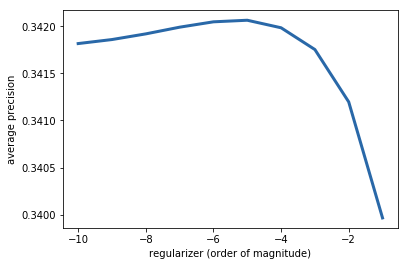

In [17]:
grid = [2**i for i in range(-10,0)]
average_precision = []
for r in grid:
    print r,', ',
    w = np.linalg.solve(XTX + r*np.eye(XTX.shape[0]),XTY)
    
    Yhat = np.dot(Xtest,w)
    yflat = Ytest.reshape(Ytest.shape[0]*Ytest.shape[1])
    yhatflat = Yhat.reshape(Yhat.shape[0]*Yhat.shape[1])
    average_precision.append(average_precision_score(yflat, yhatflat))
    
fig = plt.figure()
plt.plot(range(-10,-0),average_precision,color=(41/255.,104/255.,168/255.),linewidth=3)
fig.axes[0].set_xlabel('regularizer (order of magnitude)')
fig.axes[0].set_ylabel('average precision')

Text(0,0.5,'precision')

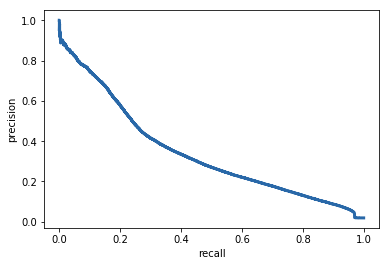

In [18]:
w = np.linalg.solve(XTX + 10e-6*np.eye(XTX.shape[0]),XTY)
Yhat = np.dot(Xtest,w)
yflat = Ytest.reshape(Ytest.shape[0]*Ytest.shape[1])
yhatflat = Yhat.reshape(Yhat.shape[0]*Yhat.shape[1])
precision, recall, _ = precision_recall_curve(yflat, yhatflat)

fig = plt.figure()
plt.plot(recall,precision,color=(41/255.,104/255.,168/255.),linewidth=3)
fig.axes[0].set_xlabel('recall')
fig.axes[0].set_ylabel('precision')

# MIREX evaluation

In [19]:
import mir_eval

In [20]:
def estimate(X,subdiv=50):
    return np.dot(X,w)

In [21]:
Xvalidation = np.zeros([50*len(train_data),d])
Yvalidation = np.zeros([50*len(train_data),m])
for i in range(len(train_data)):
    recording = train_data[i]
    print recording, ',',
    X,Y = data[recording]
    # 50 random samples from each recording
    s = np.random.randint(window_size/2,len(X)-window_size/2,50)
    for j in range(50):
        norm = np.linalg.norm(X[s[j]-window_size/2:s[j]+window_size/2]) + 10e-6
        #Xvalidation[50*i+j] = np.log(1 + np.abs(fft(X[s[j]-window_size/2:s[j]+window_size/2]/norm))[0:d])
        Xvalidation[50*i+j] = featurize(X[s[j]-window_size/2:s[j]+window_size/2])
        
        # label stuff that's on in the center of the window
        for label in Y[s[j]]:
            Yvalidation[50*i+j,label.data[1]] = 1

1788 , 1789 , 2659 , 2127 , 1818 , 2614 , 2138 , 2297 , 2131 , 1812 , 1775 , 2322 , 1777 , 1776 , 1771 , 2325 , 1772 , 2486 , 2487 , 2564 , 2529 , 2528 , 2480 , 2481 , 2154 , 2155 , 2156 , 2157 , 2150 , 2151 , 2244 , 1752 , 2247 , 2158 , 2159 , 2242 , 2243 , 2466 , 1759 , 2462 , 2463 , 1793 , 1792 , 1791 , 1790 , 2562 , 1757 , 2210 , 2619 , 2106 , 1859 , 2294 , 1755 , 2555 , 2550 , 1829 , 1828 , 2318 , 2319 , 2491 , 1824 , 2314 , 2315 , 2313 , 2310 , 1822 , 2411 , 2397 , 2392 , 2393 , 2390 , 2140 , 2283 , 2194 , 1750 , 2149 , 2148 , 2477 , 2476 , 2492 , 2473 , 2472 , 2471 , 2289 , 2147 , 2557 , 2568 , 2494 , 2209 , 1922 , 1923 , 2497 , 2542 , 2540 , 2195 , 2556 , 2410 , 2300 , 2302 , 2305 , 2304 , 2307 , 2228 , 2381 , 2177 , 2383 , 2384 , 2389 , 2415 , 2178 , 2179 , 2077 , 2076 , 2075 , 2288 , 2443 , 2607 , 1742 , 2444 , 2603 , 2608 , 2282 , 2391 , 2284 , 2527 , 2285 , 1933 , 1932 , 1931 , 2320 , 2521 , 2398 , 2523 , 2350 , 2081 , 1763 , 2239 , 1773 , 1728 , 1729 , 2576 , 1727 , 1835 ,

. . . . . 0.502


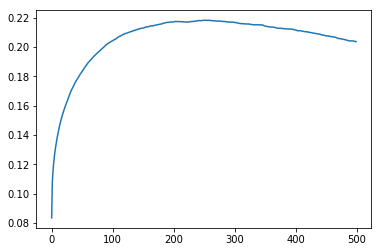

In [22]:
Yhatbase = estimate(Xvalidation)

# single threshold
density = 500
P = np.empty(density)
R = np.empty(density)
F = np.empty(density)
for i in np.arange(density):
    if i % 100 == 0: print '.',
    c = i/float(density)
    Yhat = Yhatbase>c
    true_positives = np.sum(Yhat*Yvalidation)
    P[i] = true_positives/np.sum(Yhat)
    R[i] = true_positives/np.sum(Yvalidation)
    F[i] = 2*(P[i]*R[i])/(P[i]+R[i])

plt.plot(F)
i = np.argmax(F)
c = i/float(density)
print c

In [23]:
Yhatbase = estimate(Xtest)

Yhat = Yhatbase>c
Yhatlist = []
Ytestlist = []
for i in range(len(Yhat)):
    fhat = []
    ftest = []
    for note in range(128):
        if Yhat[i][note] == 1:
            fhat.append(440.*2**((note - 69.)/12.))
        if Ytest[i][note] == 1:
            ftest.append(440.*2**((note - 69.)/12.))
    Yhatlist.append(np.array(fhat))
    Ytestlist.append(np.array(ftest))

In [24]:
P,R,Acc,Esub,Emiss,Efa,Etot,cP,cR,cAcc,cEsub,cEmiss,cEfa,cEtot = \
mir_eval.multipitch.metrics(np.arange(len(Ytestlist))/100.,Ytestlist,np.arange(len(Yhatlist))/100.,Yhatlist)

print P
print R
print Acc
print Etot
print Esub
print Emiss
print Efa

print '-----'

print cP
print cR
print cAcc
print cEtot
print cEsub
print cEmiss
print cEfa

0.660976910767
0.157405727144
0.145646881034338
0.8696693644975139
0.05366021848800494
0.7889340543679454
0.02707509164156353
-----
0.729253981559
0.173665299604
0.16314632025776096
0.8534097920371647
0.03740064602765579
0.7889340543679454
0.02707509164156353


# Precision/Recall

In [25]:
Yhattestbase = estimate(Xtest)
Yhat = Yhattestbase>c
true_positives = np.sum(Yhat*Ytest)
P = true_positives/(np.sum(Yhat))
R = true_positives/(np.sum(Ytest))
F = 2*(P*R)/(P+R)
print P
print R
print F

0.660976910767355
0.15740572714404966
0.2542613844552903


0.3417596070304073


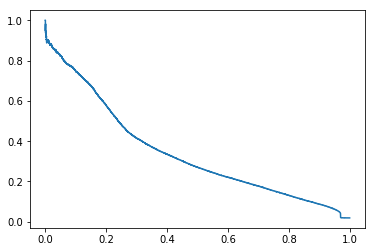

In [26]:
yflat = Ytest.reshape(Ytest.shape[0]*Ytest.shape[1])
yhatflat = Yhattestbase.reshape(Yhattestbase.shape[0]*Yhattestbase.shape[1])

precision, recall, _ = precision_recall_curve(yflat, yhatflat)
ap = average_precision_score(yflat, yhatflat)
plt.plot(recall,precision)
print ap

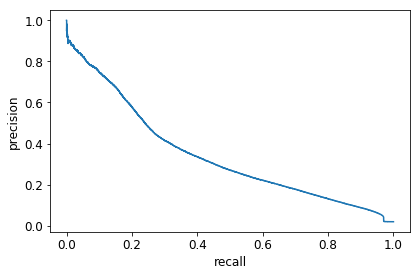

In [27]:
plt.rcParams.update({'font.size': 12})

fig = plt.figure()
plt.plot(recall,precision)
fig.axes[0].set_xlabel('recall')
fig.axes[0].set_ylabel('precision')

plt.tight_layout()
plt.savefig('linear_pr.eps',format='eps', dpi=1000)